# Demo: Reject workflow + explanations

Learning objectives:
- Show how to initialize and use a reject learner alongside calibrated explanations.
- Demonstrate how to triage rejected instances with factual and alternative explanations.

Time to run: ~2–5 minutes (toy dataset)

Notes: the code below checks for the presence of `initialize_reject_learner` and `predict_reject` APIs and falls back gracefully if they are missing.

In [4]:
# Minimal setup: train a small classifier and calibrate an explainer
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

from calibrated_explanations import CalibratedExplainer

data = load_breast_cancer(as_frame=True)
X = data.data.values.astype(float)
y = data.target.values.astype(int)
feature_names = list(data.feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=0, stratify=y_train)

model = RandomForestClassifier(n_estimators=50, random_state=0)
model.fit(X_prop_train, y_prop_train)

ce = CalibratedExplainer(model, X_cal, y_cal, feature_names=feature_names)
print('CalibratedExplainer created')

CalibratedExplainer created


In [5]:
# Initialize reject learner if available and compute reject decisions/scores
reject_scores = None
if hasattr(ce, 'initialize_reject_learner'):
    try:
        ce.initialize_reject_learner()
        print('Reject learner initialized')
    except Exception as exc:
        print('Failed to initialize reject learner:', exc)

if hasattr(ce, 'predict_reject'):
    try:
        reject_scores = ce.predict_reject(X_test)
        print('predict_reject output:', type(reject_scores), getattr(reject_scores, 'shape', 'scalar or list'))
    except Exception as exc:
        print('predict_reject failed:', exc)
else:
    print('No reject API available on this explainer object in this environment.')

Reject learner initialized
predict_reject output: <class 'tuple'> scalar or list


Indices to explain: [21, 74, 99]
--- Instance 21 ---


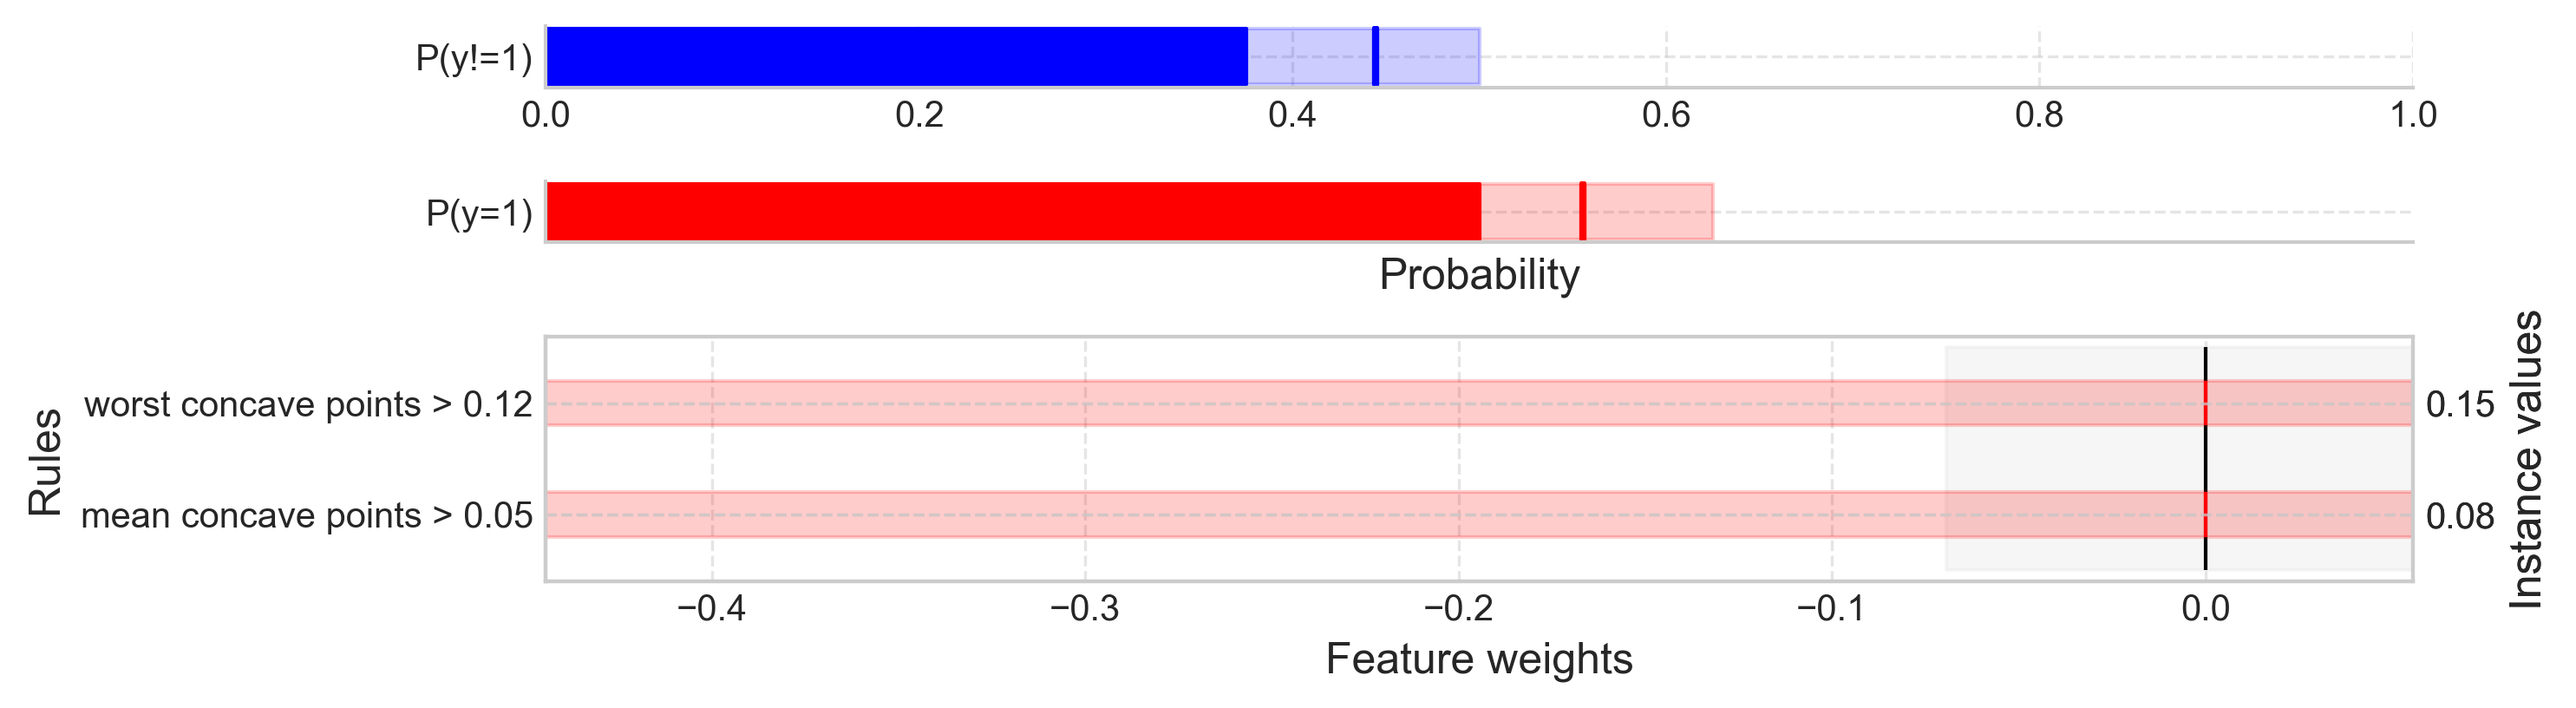

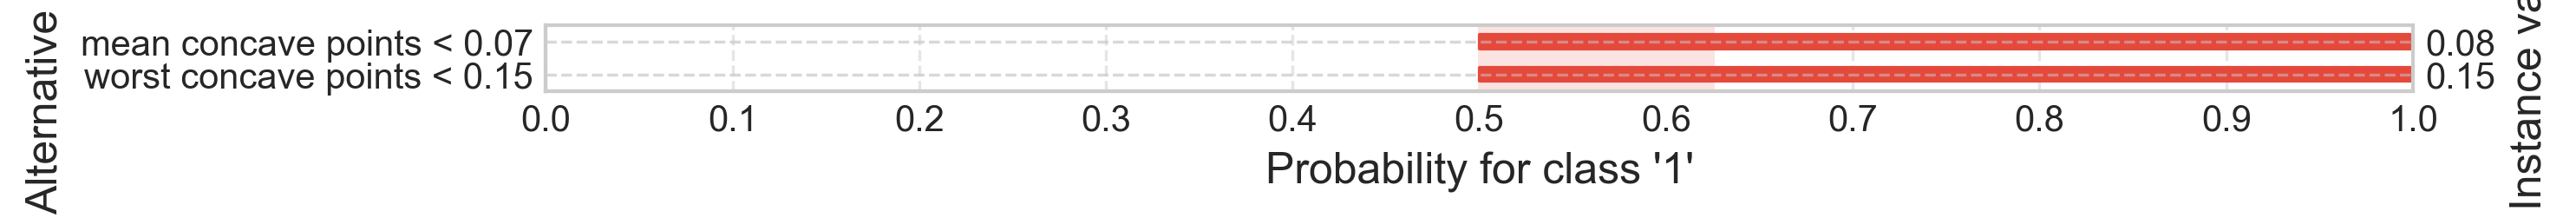

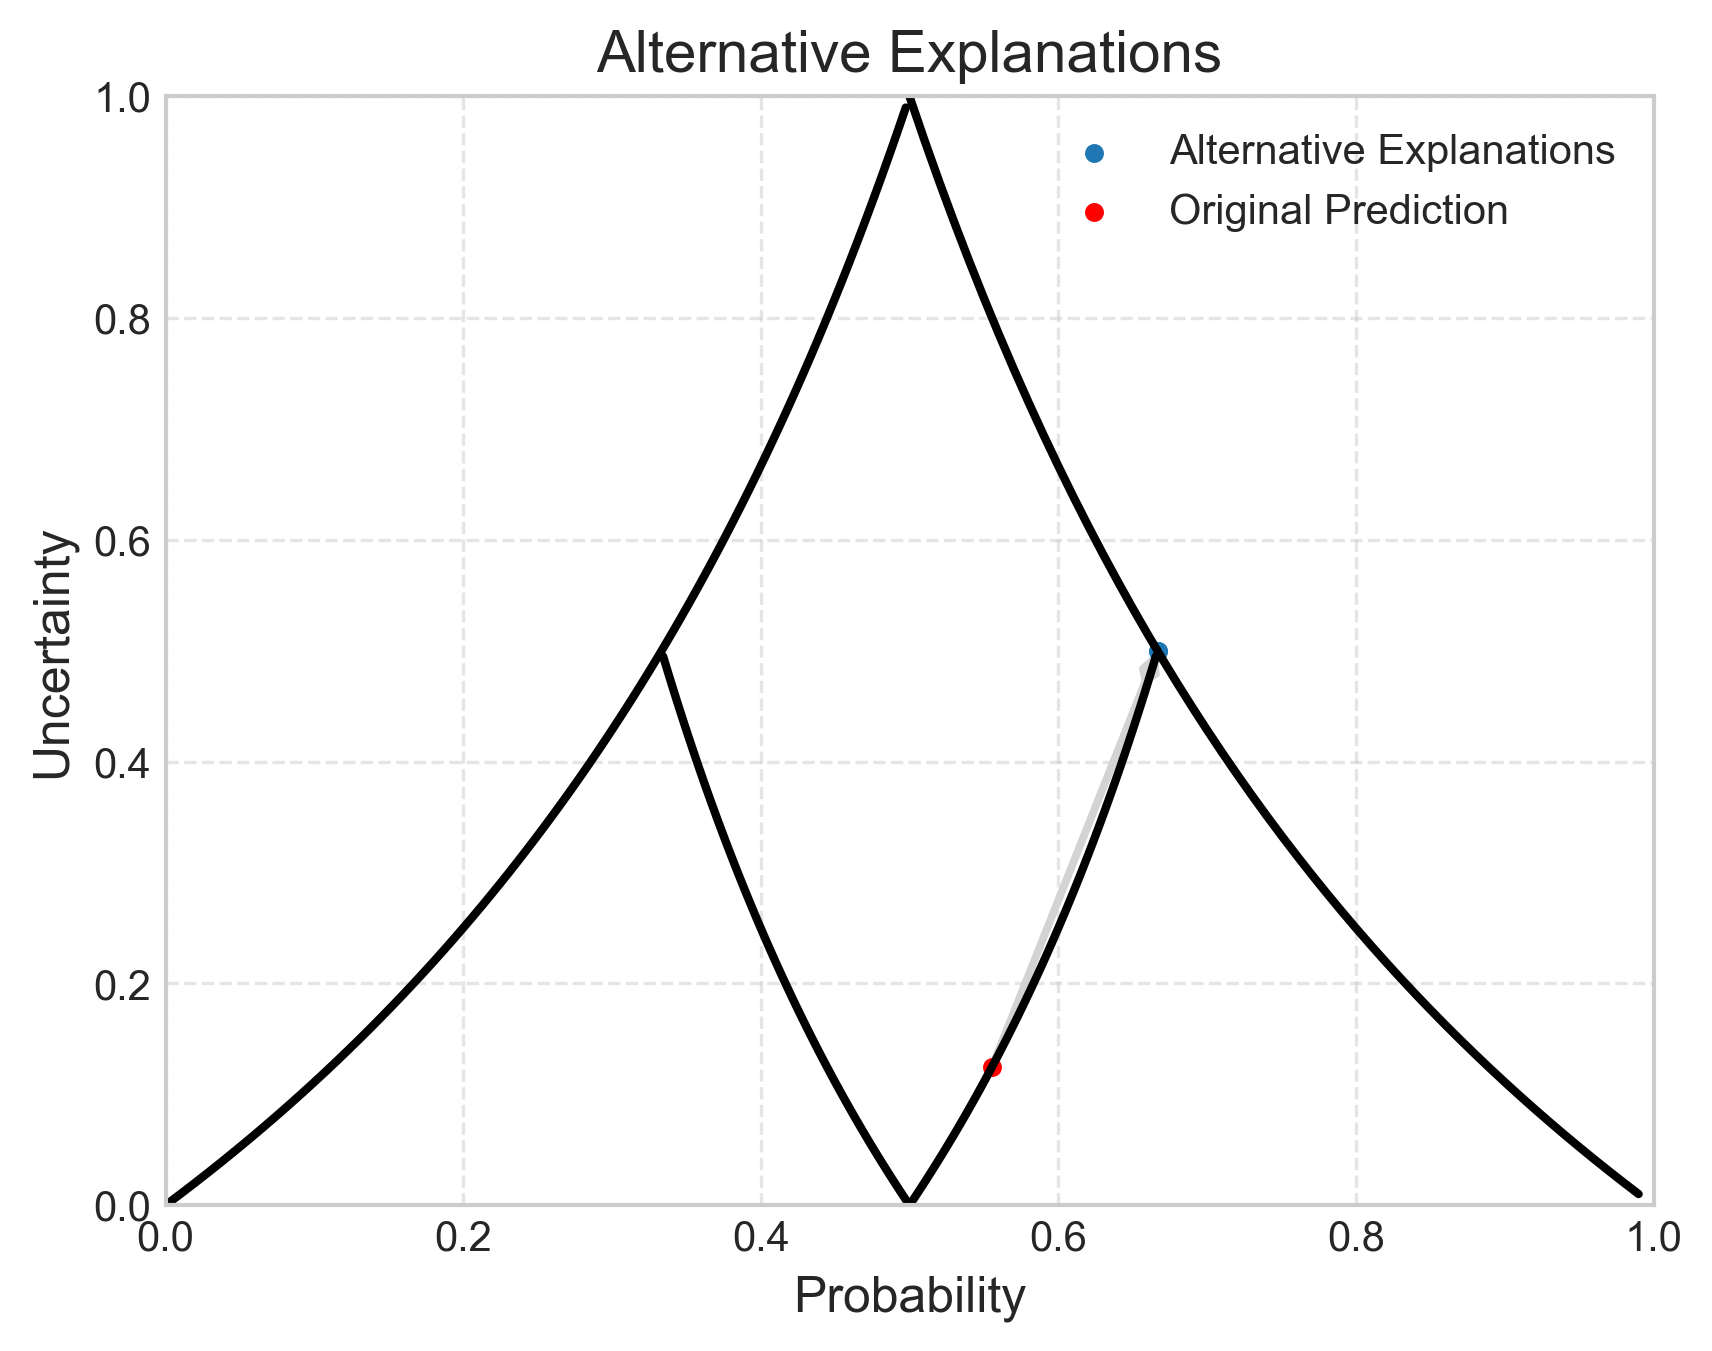

--- Instance 74 ---


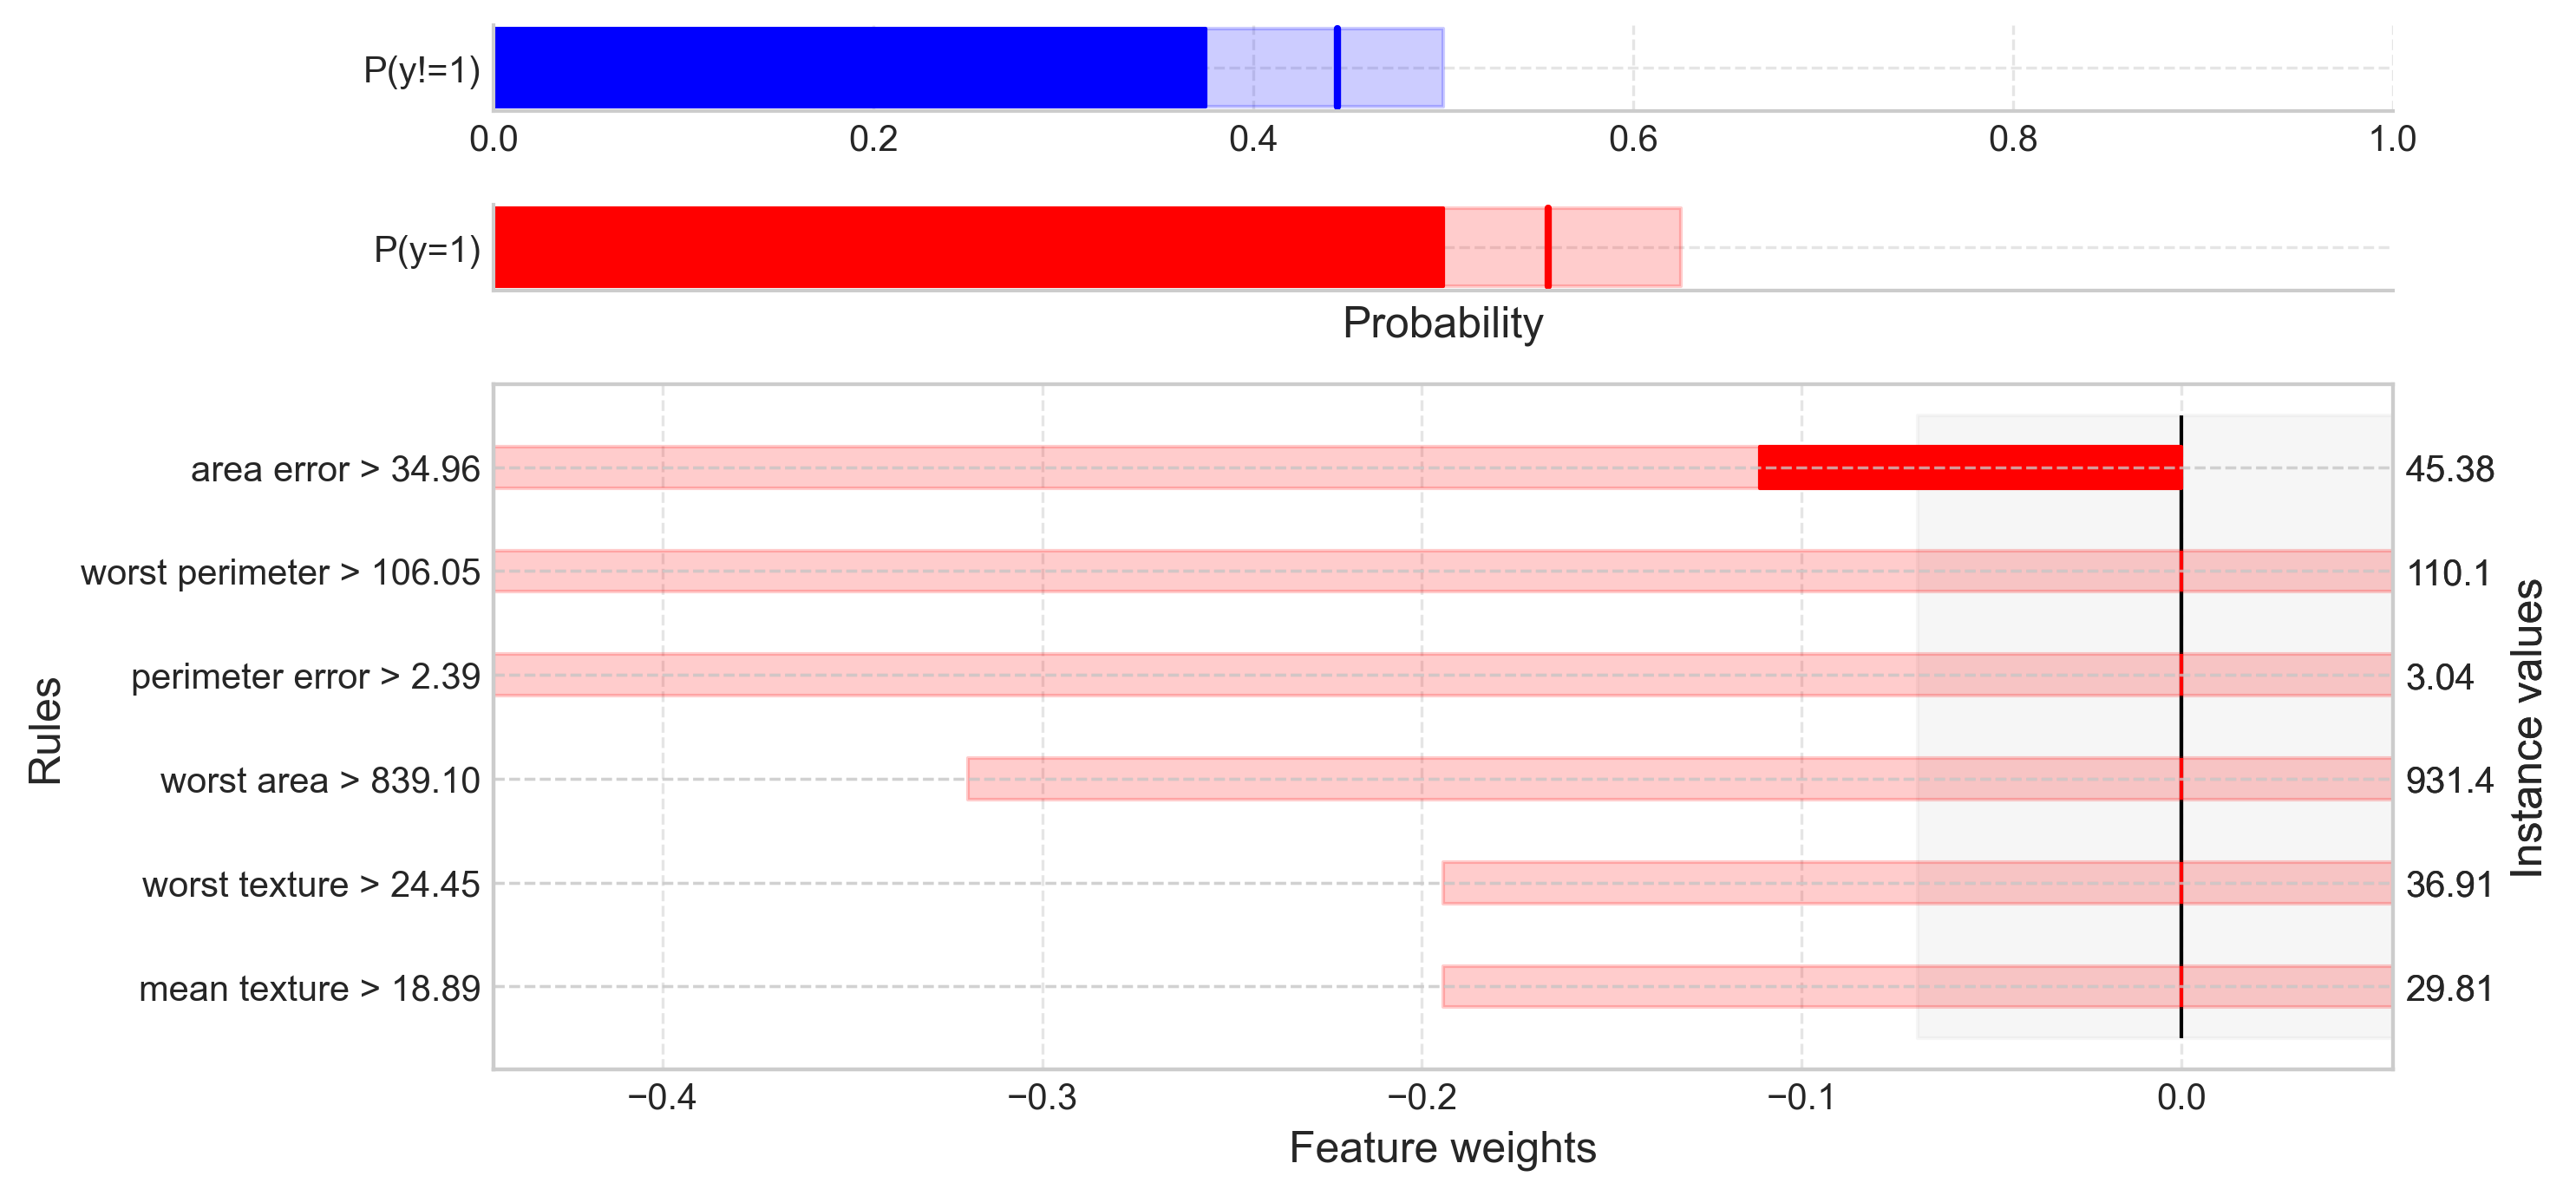

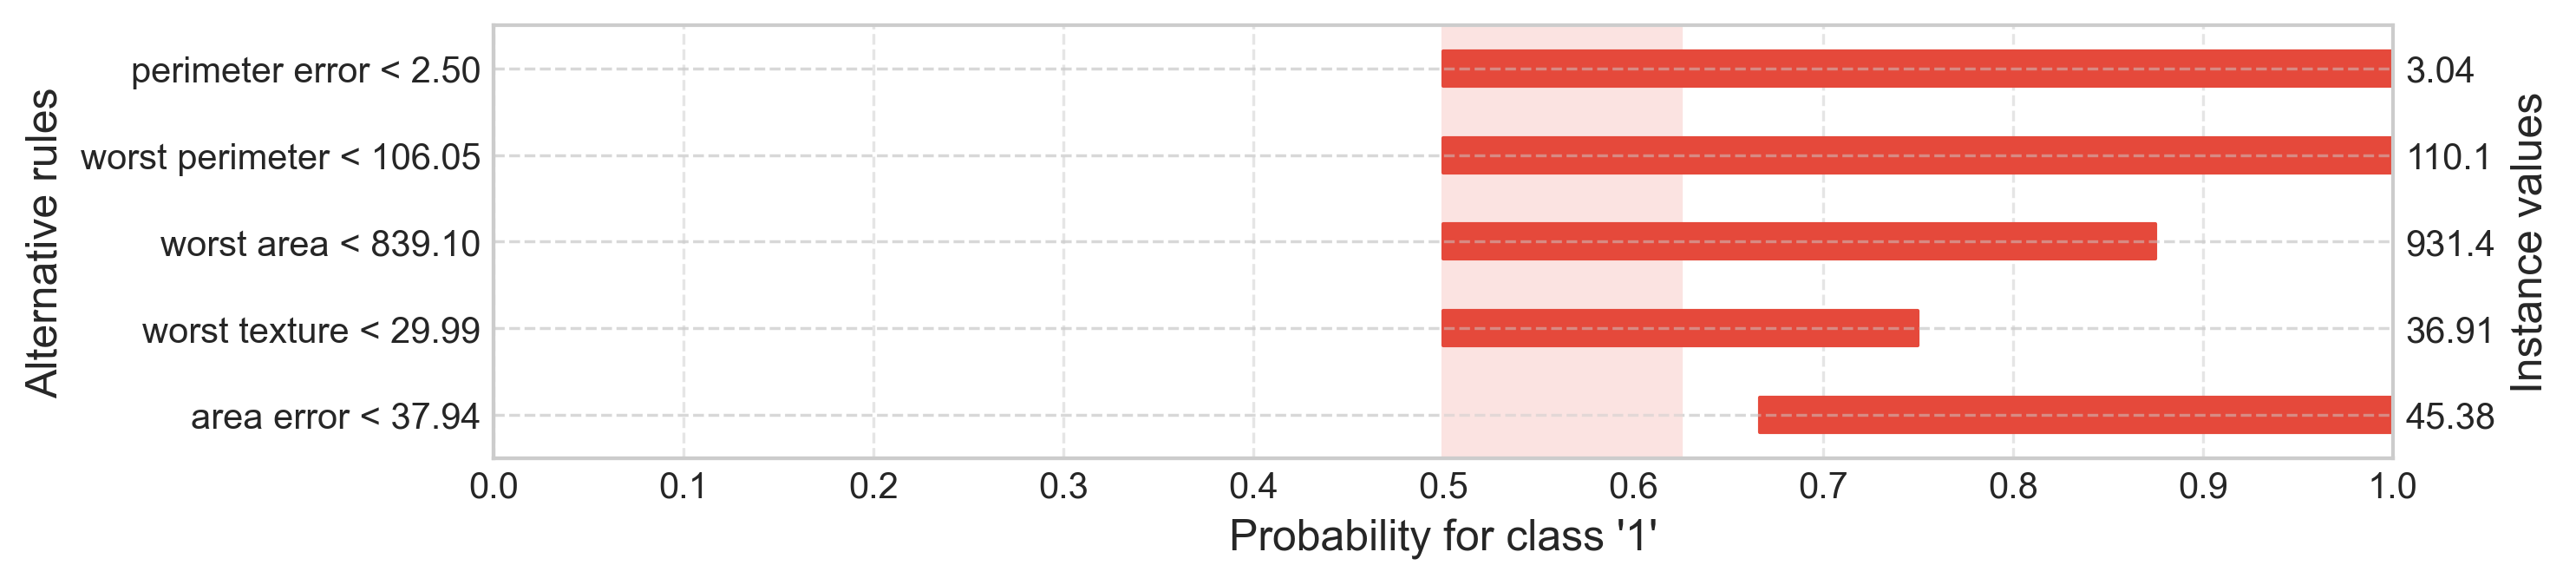

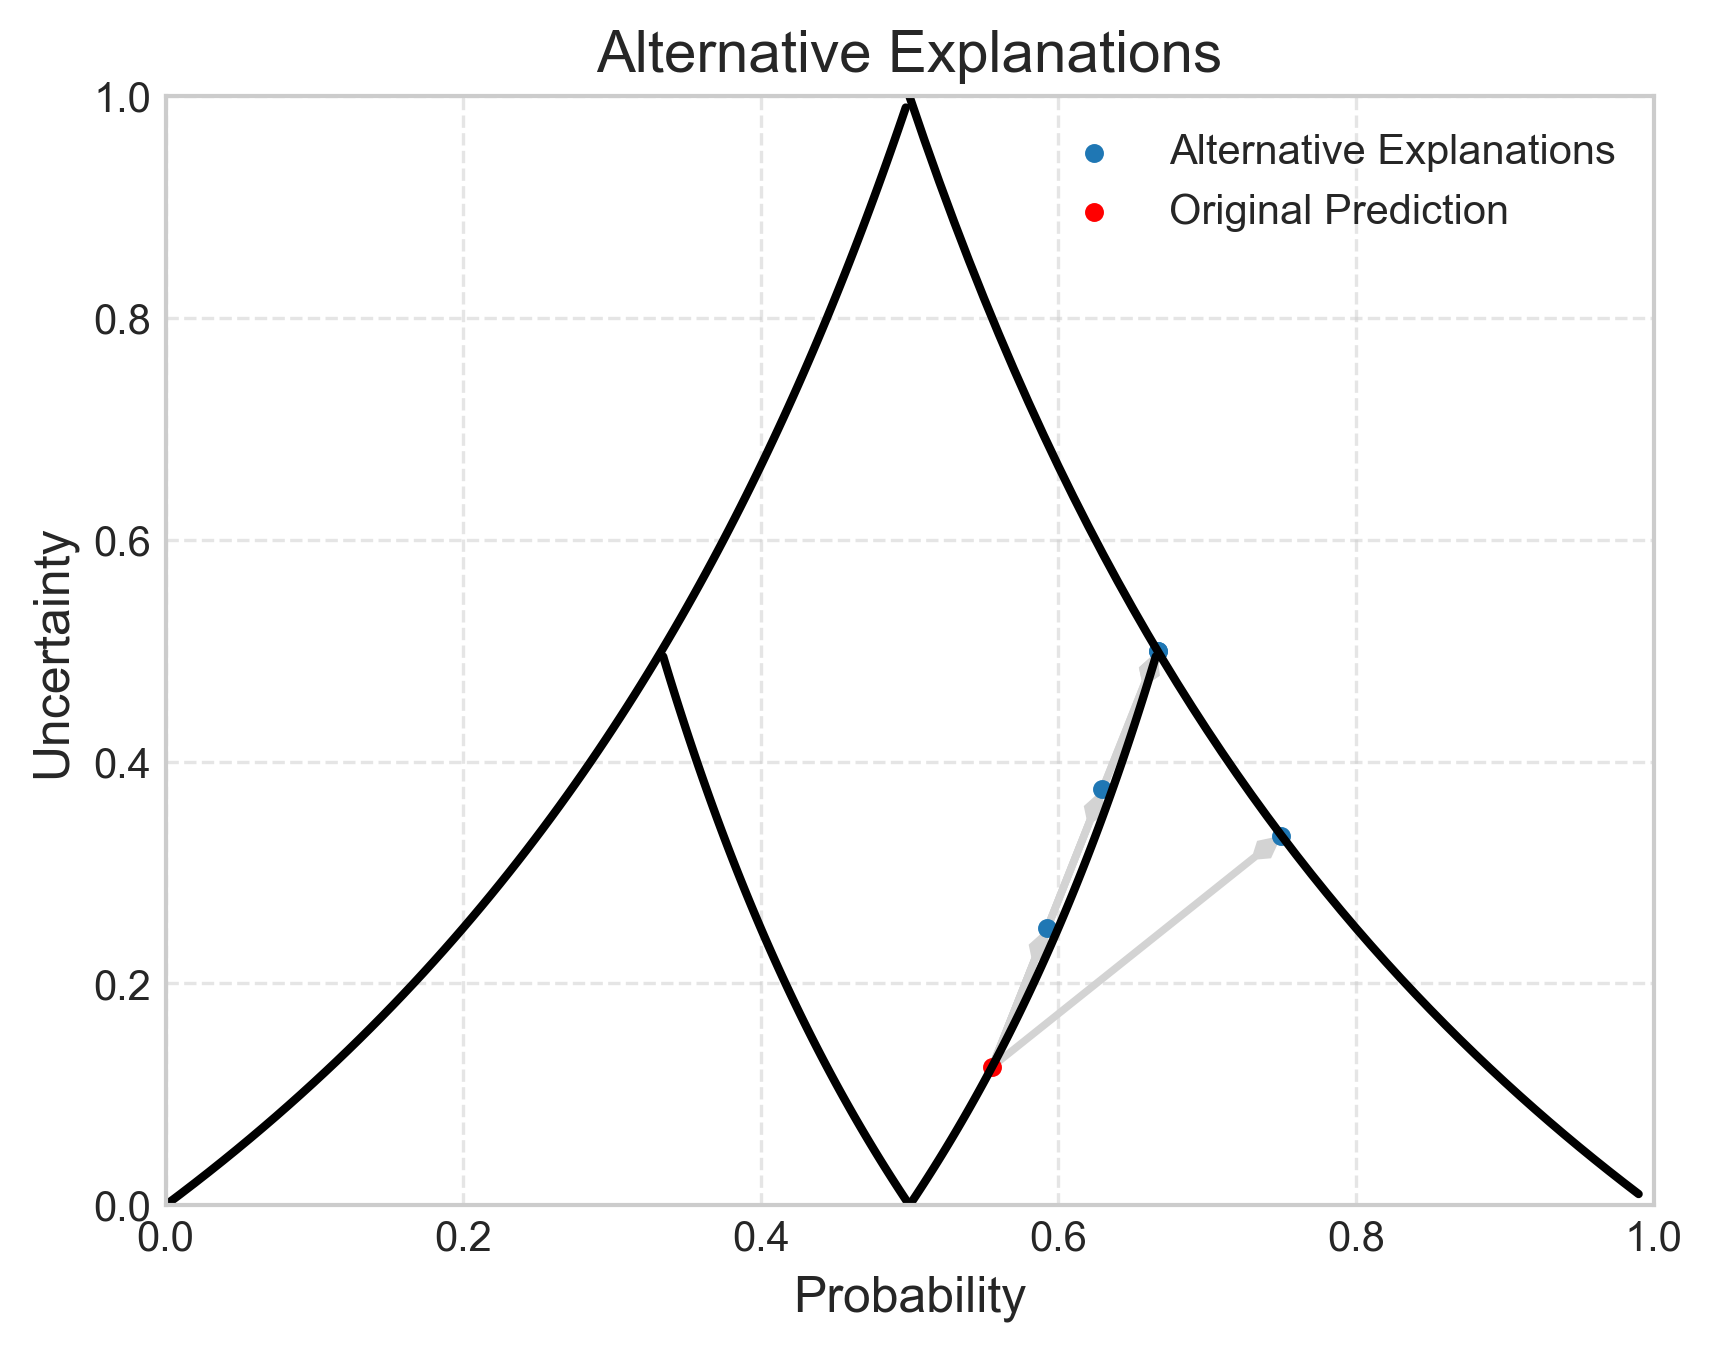

--- Instance 99 ---


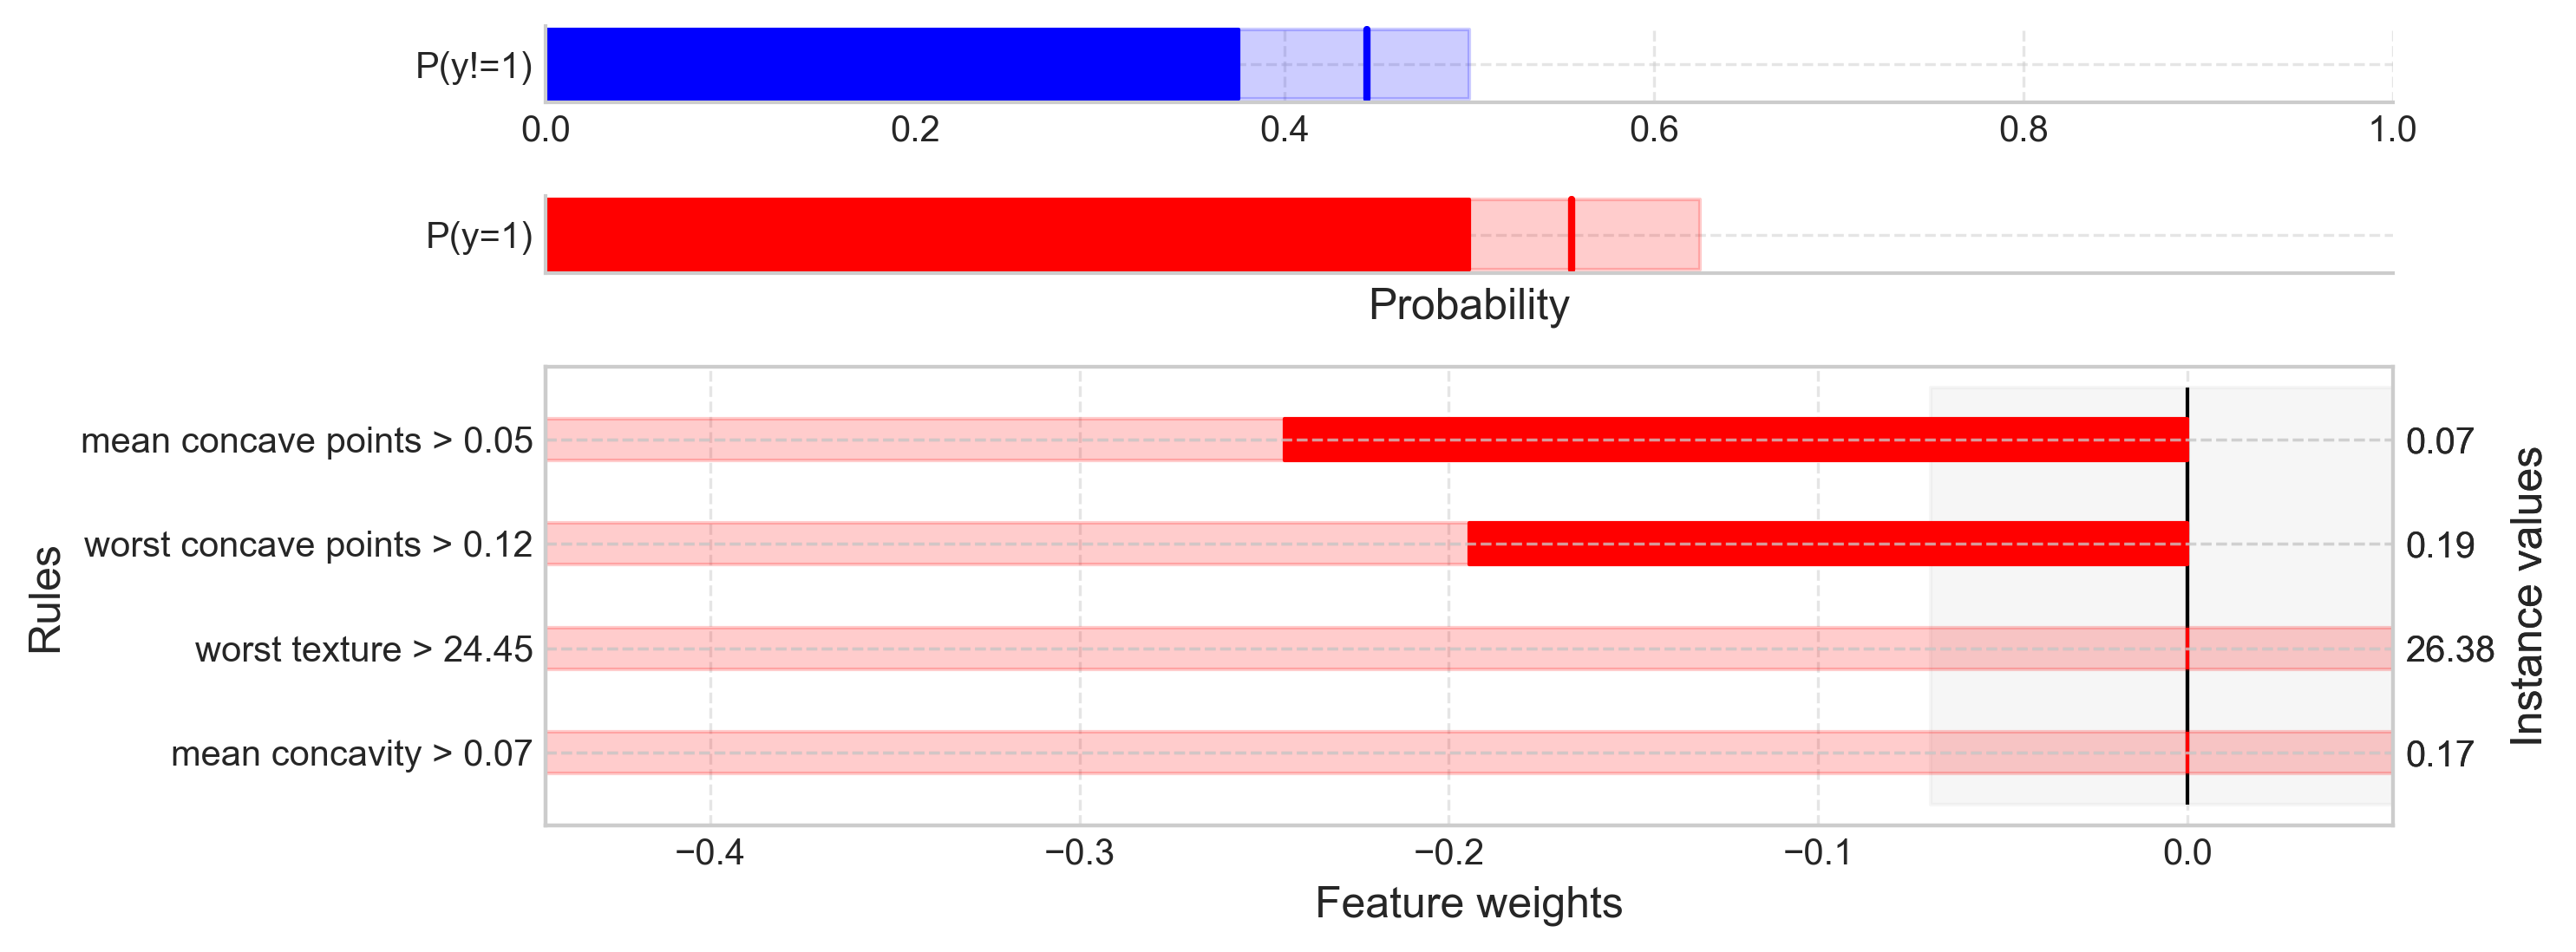

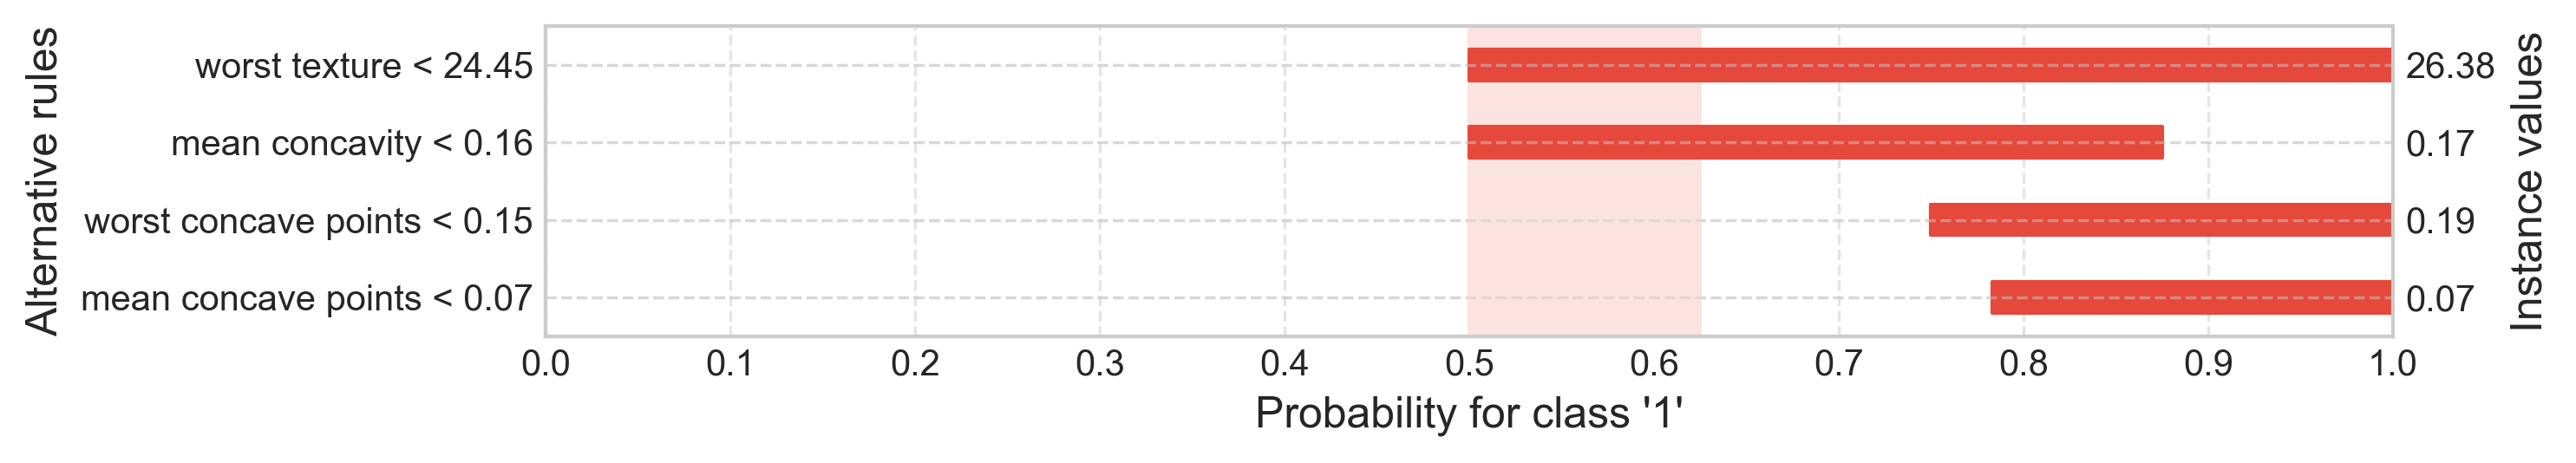

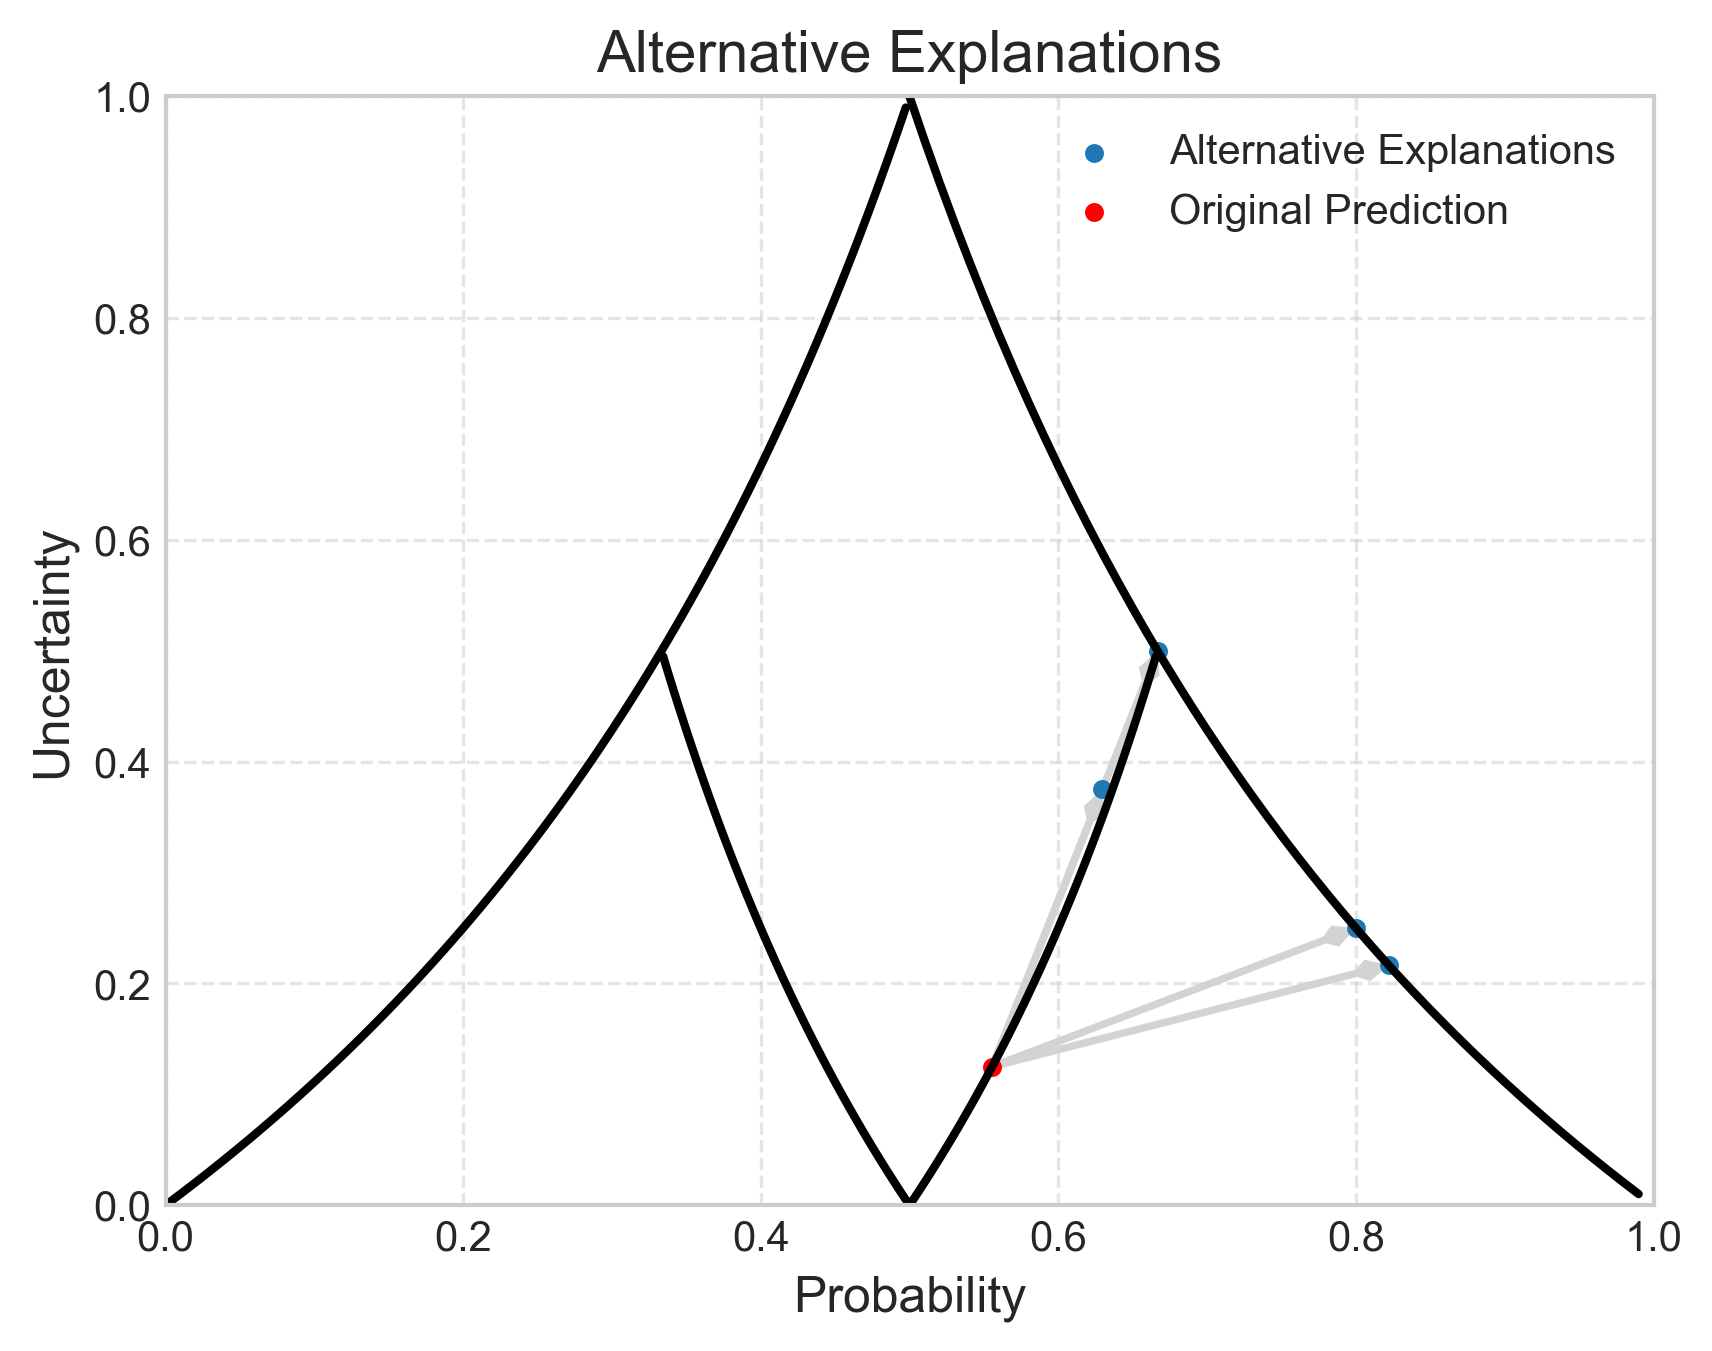

In [7]:
# Triage and explain any rejected instances (or high-score ones)
indices_to_explain = []
n_test = len(X_test)

def _coerce_reject_scores(rs, n):
    """Try several common shapes and return a 1D numpy array of length n or None."""
    import pandas as _pd
    # direct numpy array
    if isinstance(rs, np.ndarray):
        return rs
    # pandas Series
    try:
        if isinstance(rs, _pd.Series):
            return rs.values
    except Exception:
        pass
    # tuple/list common pattern: (scores, ...) or (mask, ...). If first element matches n, use it
    if isinstance(rs, (list, tuple)) and len(rs) in (2, 3):
        first = rs[0]
        try:
            if hasattr(first, '__len__') and len(first) == n:
                return np.asarray(first)
        except Exception:
            pass
    # dict pattern: try common keys or any value with correct length
    if isinstance(rs, dict):
        for key in ('scores', 'score', 'reject', 'mask', 'proba'):
            if key in rs:
                return _coerce_reject_scores(rs[key], n)
        for v in rs.values():
            try:
                if hasattr(v, '__len__') and len(v) == n:
                    return np.asarray(v)
            except Exception:
                continue
    # generic iterable: try to map each element to a scalar (mean of array, or the scalar itself)
    if isinstance(rs, (list, tuple)):
        scalars = []
        for item in rs:
            if np.isscalar(item):
                scalars.append(item)
                continue
            try:
                arr = np.asarray(item)
                if arr.size == 1:
                    scalars.append(float(arr))
                else:
                    scalars.append(float(np.mean(arr)))
            except Exception:
                scalars.append(np.nan)
        if len(scalars) == n:
            return np.asarray(scalars)
    return None

if reject_scores is None:
    print('No reject signals available — showing top-1 uncertain instance as an example')
    # Fallback: pick instance with prediction probability closest to 0.5
    proba, _ = ce.predict_proba(X_test, uq_interval=False)
    scores = np.abs(np.array(proba) - 0.5)
    idx = int(np.argmin(scores))
    indices_to_explain = [idx]
else:
    arr = _coerce_reject_scores(reject_scores, n_test)
    if arr is None:
        print('Could not coerce reject_scores to a 1D array; falling back to top-1 uncertain instance')
        try:
            proba, _ = ce.predict_proba(X_test, uq_interval=False)
            scores = np.abs(np.array(proba) - 0.5)
            idx = int(np.argmin(scores))
            indices_to_explain = [idx]
        except Exception:
            indices_to_explain = []
    else:
        # handle boolean mask or numeric scores
        try:
            if arr.dtype == bool or arr.dtype == np.bool_:
                indices_to_explain = list(np.where(arr)[0])
            else:
                numeric = arr.astype(float)
                indices_to_explain = list(np.where(numeric > 0.5)[0])
        except Exception:
            print('Failed to interpret coerced reject array; falling back to top-1 uncertain instance')
            try:
                proba, _ = ce.predict_proba(X_test, uq_interval=False)
                scores = np.abs(np.array(proba) - 0.5)
                idx = int(np.argmin(scores))
                indices_to_explain = [idx]
            except Exception:
                indices_to_explain = []

print('Indices to explain:', indices_to_explain)

# For each selected index, show factual and alternatives
for i in indices_to_explain:
    print(f'--- Instance {i} ---')
    factual = ce.explain_factual(X_test[i:i+1])
    factual.plot(uncertainty=True)
    alts = ce.explore_alternatives(X_test[i:i+1])
    alts.plot()
    # Optional: show triangular style if supported
    try:
        alts.plot(style='triangular')
    except Exception:
        pass


Next steps:
- Tweak the reject threshold or the reject learner training to suit your operational policy.
- Export flagged instances and their `to_telemetry()` payloads for human review or audit logs.
- If you want, I can add a short helper that builds a CSV with rejected instances and top alternative actions.